In [1]:
! squeue -u ad9701

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             54492       vdi sys/dash   ad9701  R    4:20:48      1 ood-vn27


In [2]:
%who

Interactive namespace is empty.


In [3]:
import xarray as xr
import numpy as np
import geopandas as gpd
import datetime
import matplotlib

# getting the spatial plotting function from another directory
import sys
new_path = '/home/566/ad9701/drought_probability/final_code_AU/'
if new_path not in sys.path:
    sys.path.append(new_path)
import validation_functions as myfuncs

In [4]:
# the drought region
sh_drought_reg = gpd.read_file('/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp')

# the GRACE data
data_dir = '/g/data/w97/ad9701/GRACE/'

In [5]:
ds = xr.open_dataset(data_dir + 'GRCTellus.JPL.200204_202202.GLO.RL06M.MSCNv02CRI.nc')

lat_slice = slice(-44, -10)
lon_slice = slice(112, 154)
time_slice = slice('2016-12-01', '2020-12-31')

da_lwe = ds['lwe_thickness'].sel(lat = lat_slice, lon = lon_slice, time = time_slice)
da_lwe_std = ds['uncertainty'].sel(lat = lat_slice, lon = lon_slice, time = time_slice)
da_time_bounds = ds['time_bounds'].sel(time = time_slice)

# long term grace data over the region for calculations of deviations from the seasonal cycle
time_slice_lt = slice('2002-01-01', '2021-12-31')
da_lwe_lt = ds['lwe_thickness'].sel(lat = lat_slice, lon = lon_slice, time = time_slice_lt)

In [6]:
# calculate anomalies based on long term monthly climatology
da_lwe_monClim = da_lwe_lt.groupby('time.month').mean()
da_lwe_monAnom = da_lwe.groupby('time.month') - da_lwe_monClim

In [7]:
# other variables in the GRACE dataset
sf_file = '/g/data/w97/ad9701/GRACE/CLM4.SCALE_FACTOR.JPL.MSCNv02CRI.nc'
ds_sf = xr.open_dataset(sf_file)
da_sf = ds_sf['scale_factor'].sel(lat = lat_slice, lon = lon_slice)
da_lwe_xSF = da_lwe*da_sf
da_lwe_lt_xSF = da_lwe_lt*da_sf

da_lwe_xSF_monClim = da_lwe_lt_xSF.groupby('time.month').mean()
da_lwe_xSF_monAnom = da_lwe_xSF.groupby('time.month') - da_lwe_xSF_monClim

In [8]:
# GRACE land mask
land_mask_file = '/g/data/w97/ad9701/GRACE/LAND_MASK.CRI.nc'
ds_lm = xr.open_dataset(land_mask_file)
# ds_lm.sel(lat = lat_slice, lon = lon_slice)['land_mask'].plot()
da_lm = ds_lm['land_mask'].sel(lat = lat_slice, lon = lon_slice)

In [8]:
# JPL mascon placement
mascon_placement_file = '/g/data/w97/ad9701/GRACE/JPL_MSCNv02_PLACEMENT.nc'
ds_plc = xr.open_dataset(mascon_placement_file)
# ds_plc = ds_plc.sel(mascon_lat = lat_slice, mascon_lon = lon_slice)
# print(ds_plc['mascon_lat'].values[0:10])
# print(ds_plc['mascon_lon'].values[0:10])
# print(ds_plc['mascon_rad'].values[0:10])

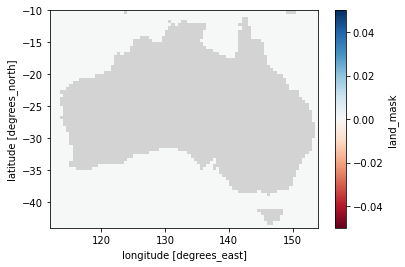

In [9]:
# creating an all nan array that can be used when data for a particular month is missing
da_nan = xr.where(da_lm == 1, np.nan, 0)

# import matplotlib
current_cmap = matplotlib.cm.get_cmap("RdBu").copy()
current_cmap.set_bad(color='lightgrey')
da_nan.plot(cmap = current_cmap)

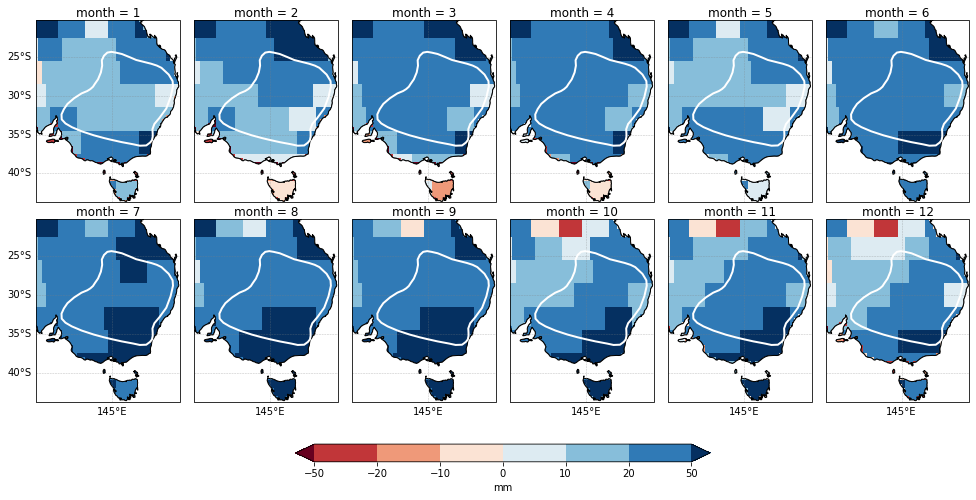

In [26]:
out_dir = 'figures/drought_2017to2020/grace/'
figname_prefix = 'grace_monClim_200204to202112'

sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'

current_cmap = matplotlib.cm.get_cmap("RdBu").copy()
current_cmap.set_bad(color='lightgrey')

lat_slice_small = slice(-44, -20)
lon_slice_small = slice(135, 154)
plot_list = [da_lwe_monClim.sel(month = i, lat = lat_slice_small, lon = lon_slice_small)*10 for i in range(1, 13)] 
subplot_title = ['month = ' + str(i) for i in range(1, 13)]

levels = [-50, -20, -10, 0, 10, 20, 50]

out_figname = figname_prefix
myfuncs.draw_pcolormesh_Npanels(plot_list, cmap = current_cmap, levels = levels, ncols = 6, nrows = 2, panel_width=2.4, panel_height=4.1, 
                                subplot_title = subplot_title, shapefile = sh_file, shapefile_color = 'white',
                                out_dir = out_dir, out_figname = out_figname, cbar_label='mm')

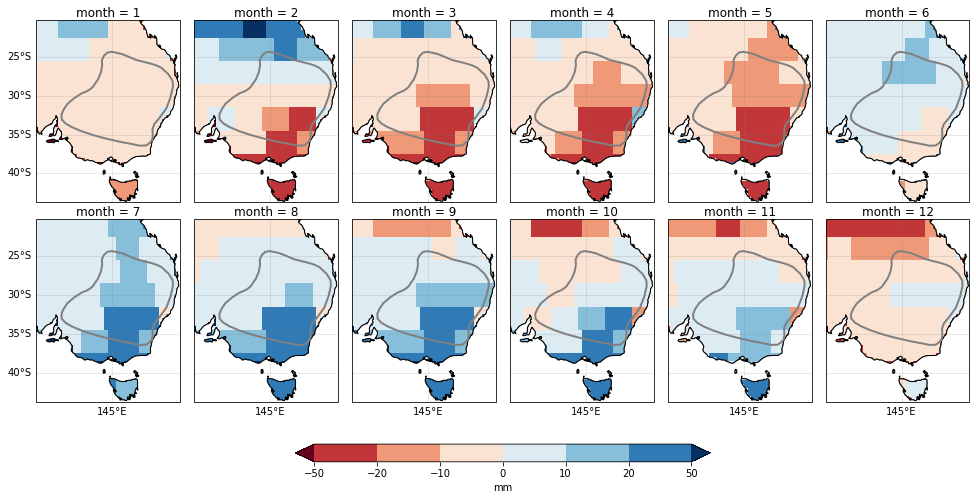

In [12]:
# what if the monthly climatology is calculated for the period 2004 to 2009 which is the baseline used for GRACE anomalies

out_dir = 'figures/drought_2017to2020/grace/'
figname_prefix = 'grace_monClim_200401to200912'

time_slice = slice('2004-01-01', '2009-12-31')
da_lwe_monClim_04to09 = da_lwe_lt.sel(time = time_slice).groupby('time.month').mean()

sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'

current_cmap = matplotlib.cm.get_cmap("RdBu").copy()
current_cmap.set_bad(color='lightgrey')

lat_slice_small = slice(-44, -20)
lon_slice_small = slice(135, 154)
plot_list = [da_lwe_monClim_04to09.sel(month = i, lat = lat_slice_small, lon = lon_slice_small)*10 for i in range(1, 13)] 
subplot_title = ['month = ' + str(i) for i in range(1, 13)]

levels = [-50, -20, -10, 0, 10, 20, 50]

out_figname = figname_prefix
myfuncs.draw_pcolormesh_Npanels(plot_list, cmap = current_cmap, levels = levels, ncols = 6, nrows = 2, panel_width=2.4, panel_height=4.1, 
                                subplot_title = subplot_title, shapefile = sh_file, shapefile_color = 'grey',
                                out_dir = out_dir, out_figname = out_figname, cbar_label='mm')

### Spatial plots of water thickness

### 1. The mass changes from GRACE data

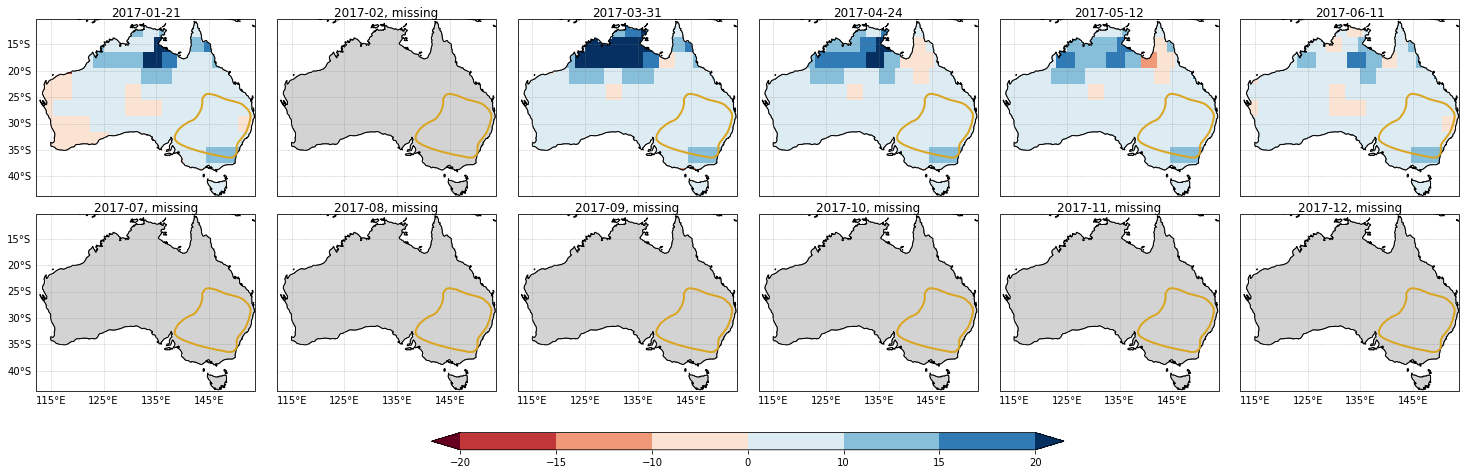

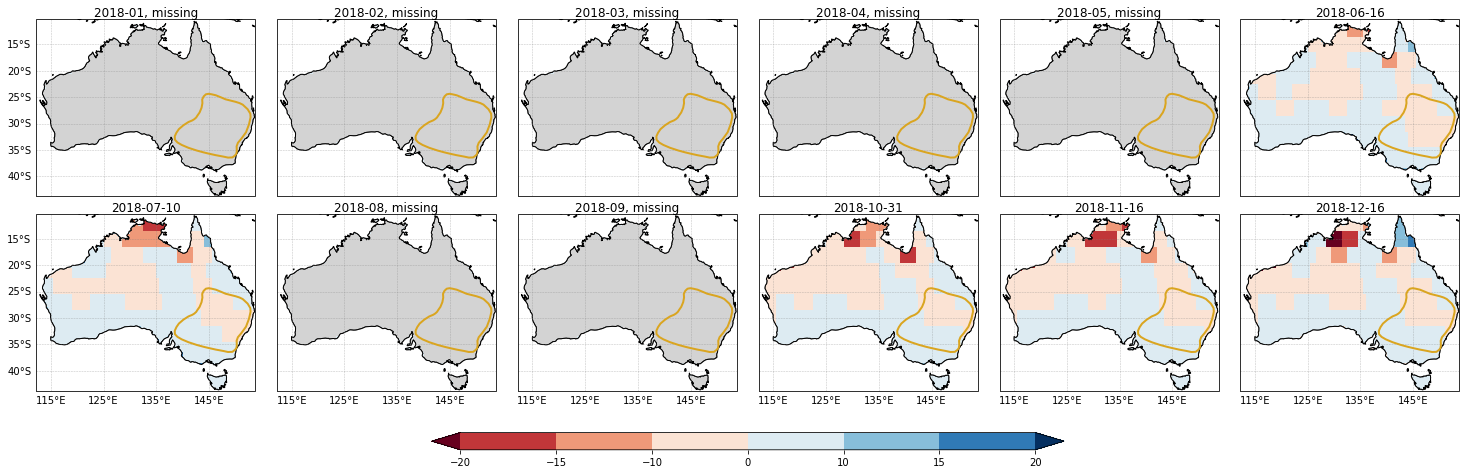

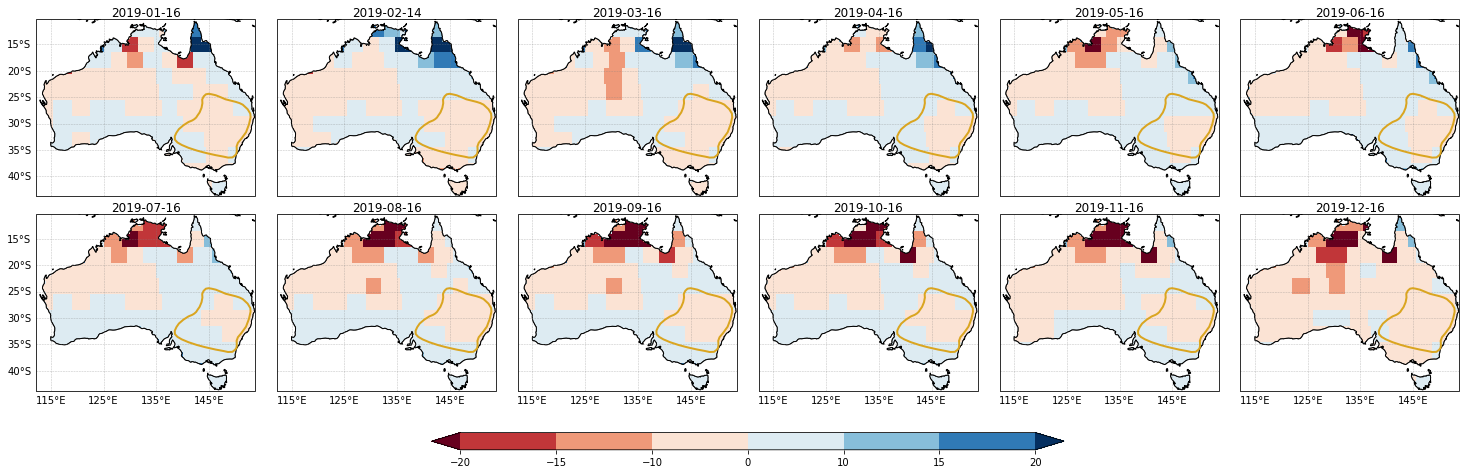

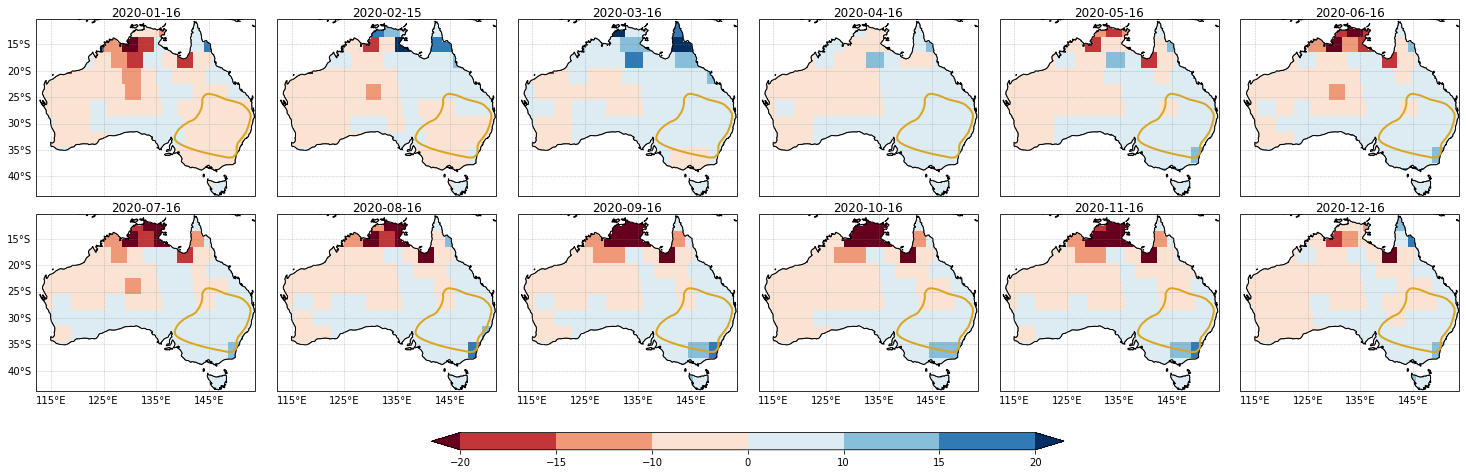

In [237]:
out_dir = 'figures/drought_2017to2020/grace/'
figname_prefix = 'grace_raw_massChanges'

sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'

current_cmap = matplotlib.cm.get_cmap("RdBu").copy()
current_cmap.set_bad(color='lightgrey')

for year in [2017, 2018, 2019, 2020]:
    da_year = da_lwe.sel(time = str(year))
    plot_list = [da_year.isel(time = i) for i in range(len(da_year.time.values))] 
    
    # find the months for which the values are missing & place an empty data array there
    mon_array = np.array(range(1, 13))
    nanInd = [x not in da_year['time.month'].values for x in mon_array]
    for i in range(len(nanInd)):
        if nanInd[i]:
            da_temp = da_nan.assign_coords({'time':datetime.datetime(year,i+1,15)})
            plot_list.insert(i, da_temp)
    
    subplot_title = [np.datetime_as_string(x.time.values, unit='D') for x in plot_list]
    for i in range(len(nanInd)):
        if nanInd[i]:
            subplot_title[i] = np.datetime_as_string(plot_list[i].time.values, unit='M') + ', missing'

    levels = [-20, -15, -10, 0, 10, 15, 20]
    out_figname = figname_prefix + '_' + str(year)
    myfuncs.draw_pcolormesh_Npanels(plot_list, cmap = current_cmap, levels = levels, ncols = 6, nrows = 2, 
                                    subplot_title = subplot_title, shapefile = sh_file, shapefile_color = 'goldenrod',
                                    out_dir = out_dir, out_figname = out_figname)

### The uncertainty in the mass changes data

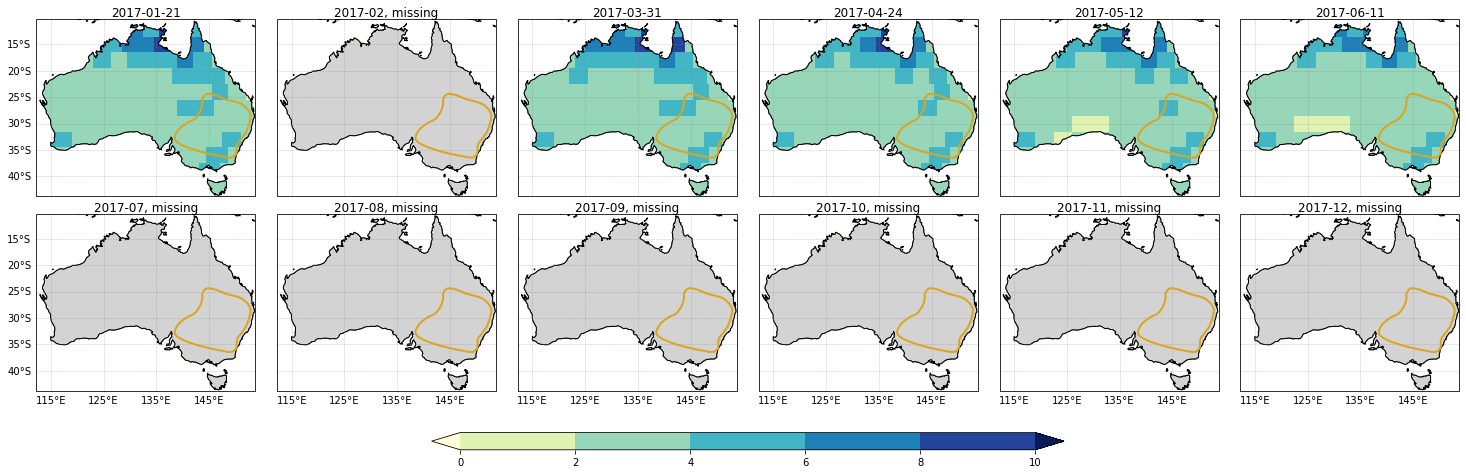

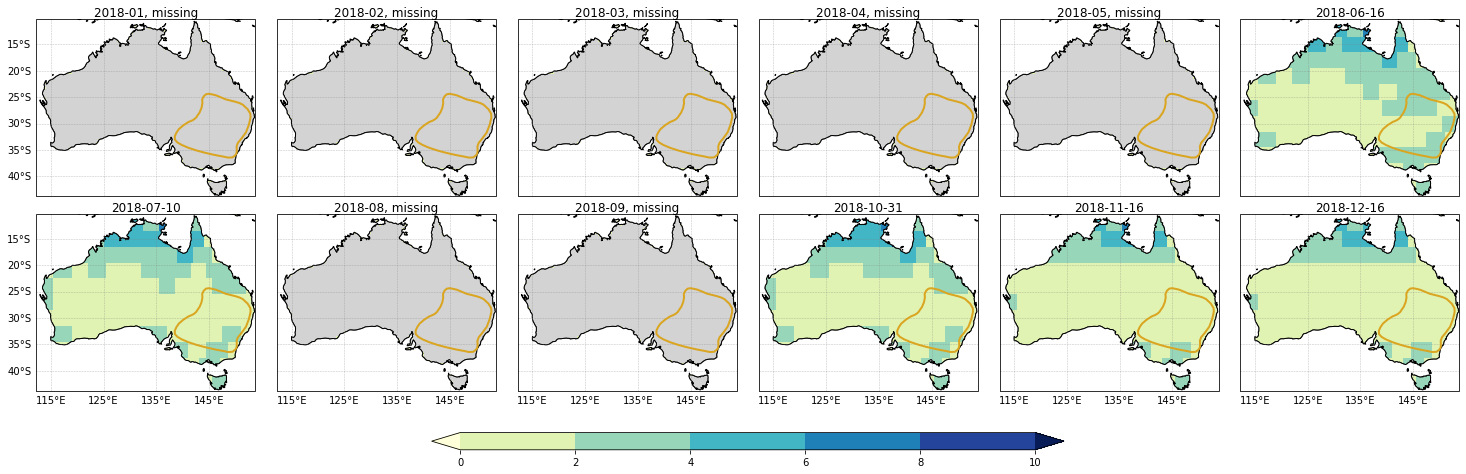

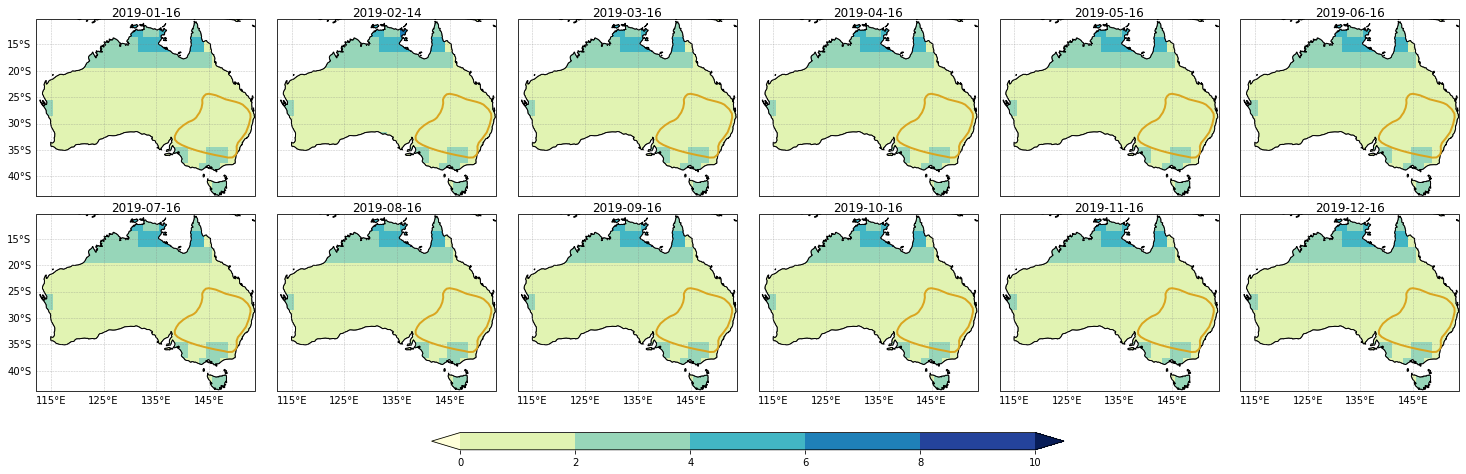

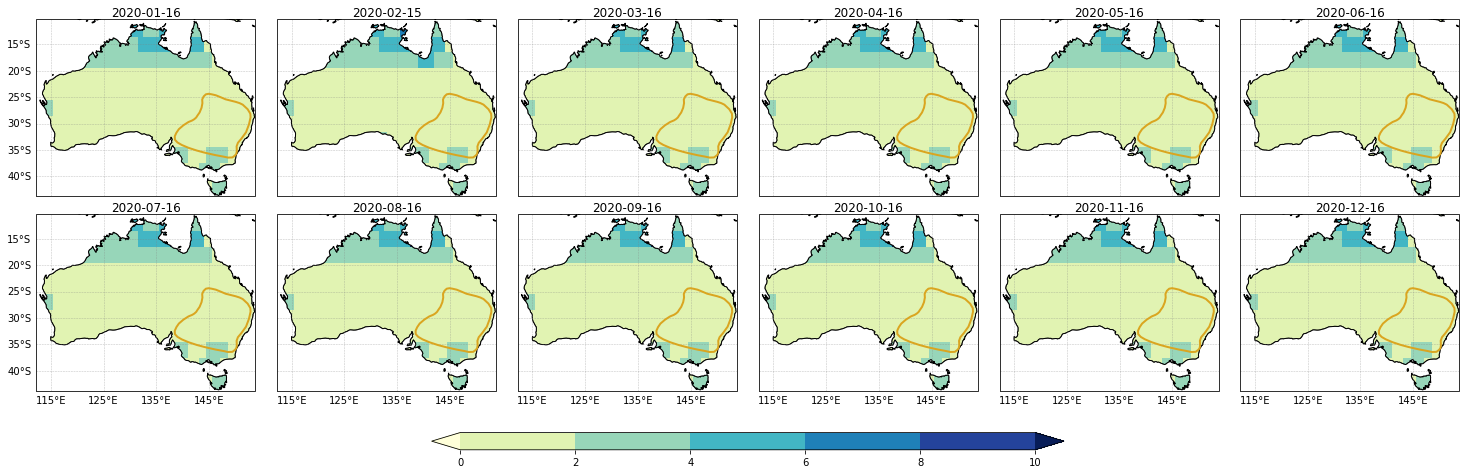

In [228]:
out_dir = 'figures/drought_2017to2020/grace/'
figname_prefix = 'grace_uncertainty'

sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'

current_cmap = matplotlib.cm.get_cmap("YlGnBu").copy()
current_cmap.set_bad(color='lightgrey')

for year in [2017, 2018, 2019, 2020]:
    da_year = da_lwe_std.sel(time = str(year))
    plot_list = [da_year.isel(time = i) for i in range(len(da_year.time.values))] 
    
    # find the months for which the values are missing & place an empty data array there
    mon_array = np.array(range(1, 13))
    nanInd = [x not in da_year['time.month'].values for x in mon_array]
    for i in range(len(nanInd)):
        if nanInd[i]:
            da_temp = da_nan.assign_coords({'time':datetime.datetime(year,i+1,15)})
            plot_list.insert(i, da_temp)
    
    subplot_title = [np.datetime_as_string(x.time.values, unit='D') for x in plot_list]
    for i in range(len(nanInd)):
        if nanInd[i]:
            subplot_title[i] = np.datetime_as_string(plot_list[i].time.values, unit='M') + ', missing'

    levels = [0, 2, 4, 6, 8, 10]
    out_figname = figname_prefix + '_' + str(year)
    myfuncs.draw_pcolormesh_Npanels(plot_list, cmap = current_cmap, levels = levels, ncols = 6, nrows = 2, 
                                    subplot_title = subplot_title, shapefile = sh_file, shapefile_color = 'goldenrod',
                                    out_dir = out_dir, out_figname = out_figname)

### The anomalies of mass changes from monthly climatology

In [256]:
myfuncs.draw_pcolormesh_Npanels?

Signature:
myfuncs.draw_pcolormesh_Npanels(
    ds_list,
    cmap='viridis',
    levels=None,
    ncols=5,
    nrows=2,
    subplot_title=None,
    main_title=None,
    out_dir=None,
    out_figname=None,
    fig_format='png',
    add_cbar=True,
    cbar_extend='both',
    cbar_label='',
    panel_width=3.66,
    panel_height=4,
    xticks=array([115, 125, 135, 145]),
    yticks=array([-40, -35, -30, -25, -20, -15]),
    shapefile=None,
    shapefile_color='black',
    sh_lwd=2,
    ds_hatch_list=None,
    hatches=['..', '..'],
    hatch_zorder=1,
)
Docstring:
Generic function to create spatial plot figure containing any number of panels, specified using ncols and nrows (defaut set to 5 cols x 2 rows)
The size of the figure is set using number of panels and individual panel_width & panel height
Uses matplotlib.pyplot.pcolormesh & adds a common horizontal colorbar at the bottom if add_cbar is True
File:      ~/drought_probability/final_code_AU/validation_functions.py
Type:      function

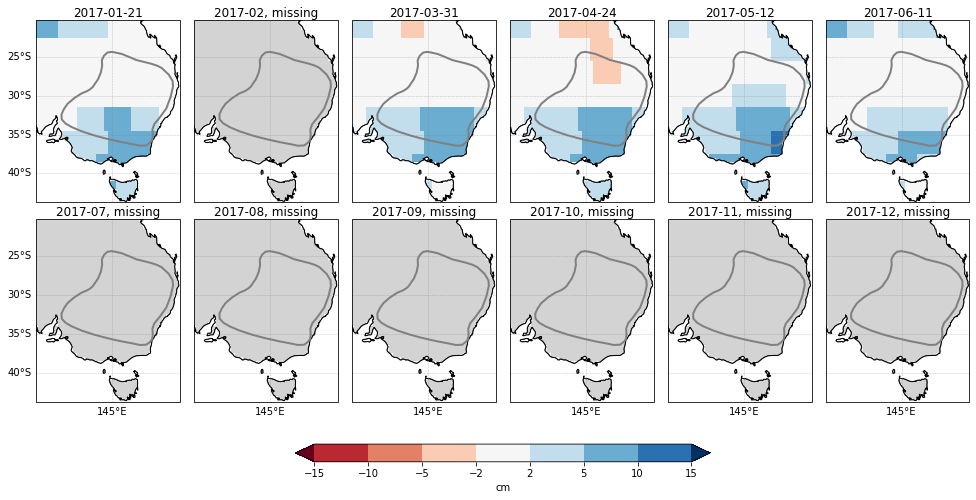

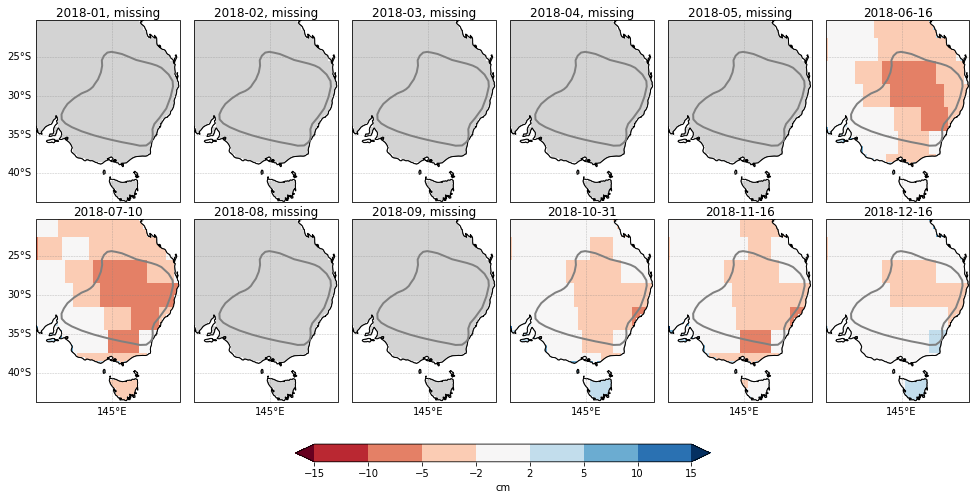

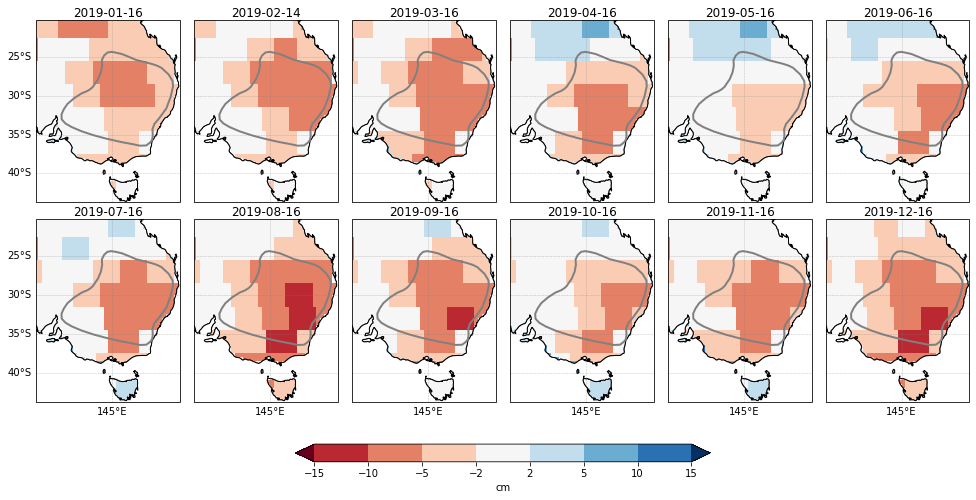

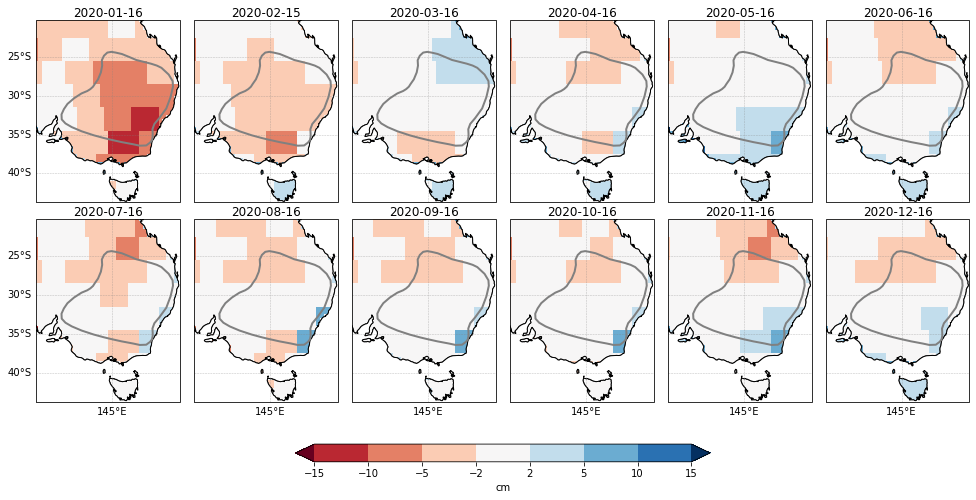

In [264]:
out_dir = 'figures/drought_2017to2020/grace/'
figname_prefix = 'grace_anomalies_fromMonClim'

sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'

current_cmap = matplotlib.cm.get_cmap("RdBu").copy()
current_cmap.set_bad(color='lightgrey')

lat_slice_small = slice(-44, -20)
lon_slice_small = slice(135, 154)

for year in [2017, 2018, 2019, 2020]:
    da_year = da_lwe_monAnom.sel(time = str(year), lat=lat_slice_small, lon=lon_slice_small)
    plot_list = [da_year.isel(time = i) for i in range(len(da_year.time.values))] 
    
    # find the months for which the values are missing & place an empty data array there
    mon_array = np.array(range(1, 13))
    nanInd = [x not in da_year['time.month'].values for x in mon_array]
    for i in range(len(nanInd)):
        if nanInd[i]:
            da_temp = da_nan.sel(lat=lat_slice_small, lon=lon_slice_small).assign_coords({'time':datetime.datetime(year,i+1,15)})
            plot_list.insert(i, da_temp)
    
    subplot_title = [np.datetime_as_string(x.time.values, unit='D') for x in plot_list]
    for i in range(len(nanInd)):
        if nanInd[i]:
            subplot_title[i] = np.datetime_as_string(plot_list[i].time.values, unit='M') + ', missing'

    levels = [-15, -10, -5, -2, 2, 5, 10, 15]
    out_figname = figname_prefix + '_' + str(year)
    myfuncs.draw_pcolormesh_Npanels(plot_list, cmap = current_cmap, ncols = 6, nrows = 2, panel_width=2.4, panel_height=4.1, levels = levels, 
                                    subplot_title = subplot_title, shapefile = sh_file, shapefile_color = 'grey',
                                    out_dir = out_dir, out_figname = out_figname, cbar_label='cm')

### 2. The mass changes * scale factor

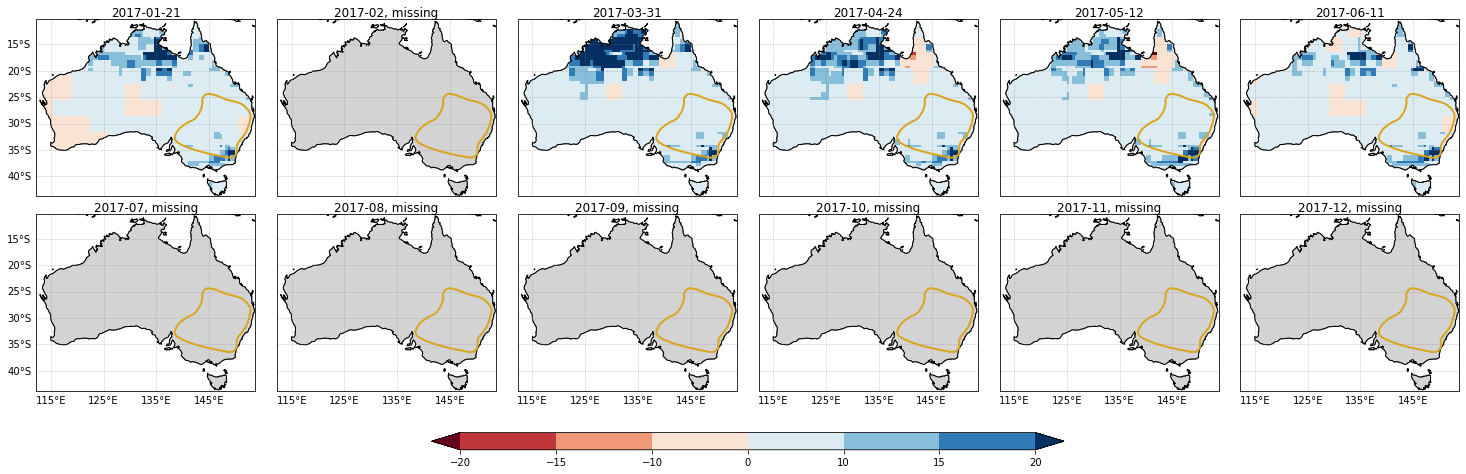

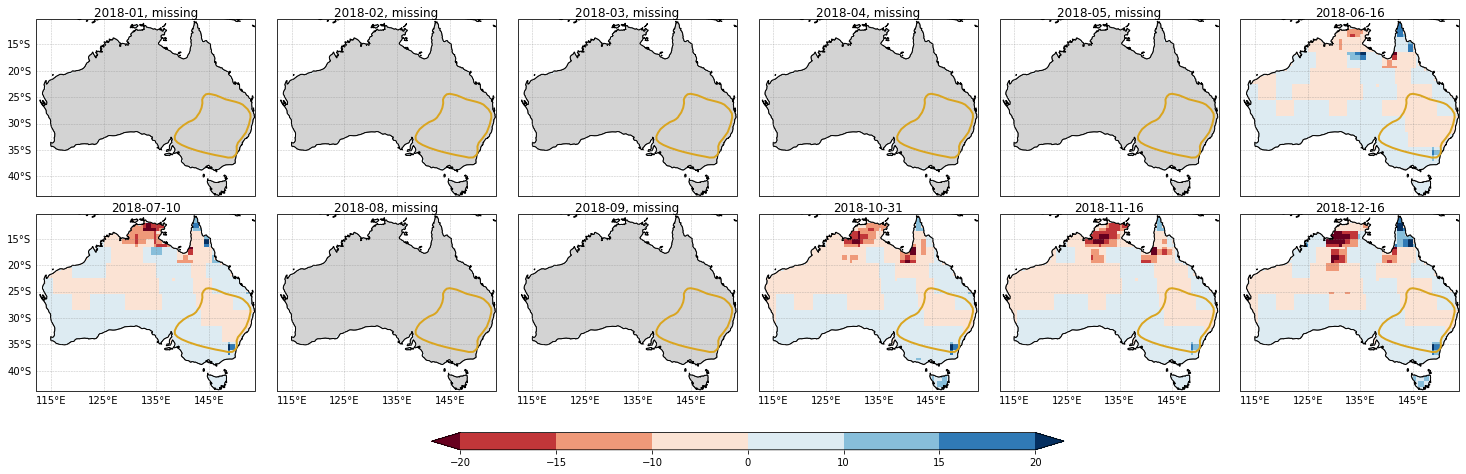

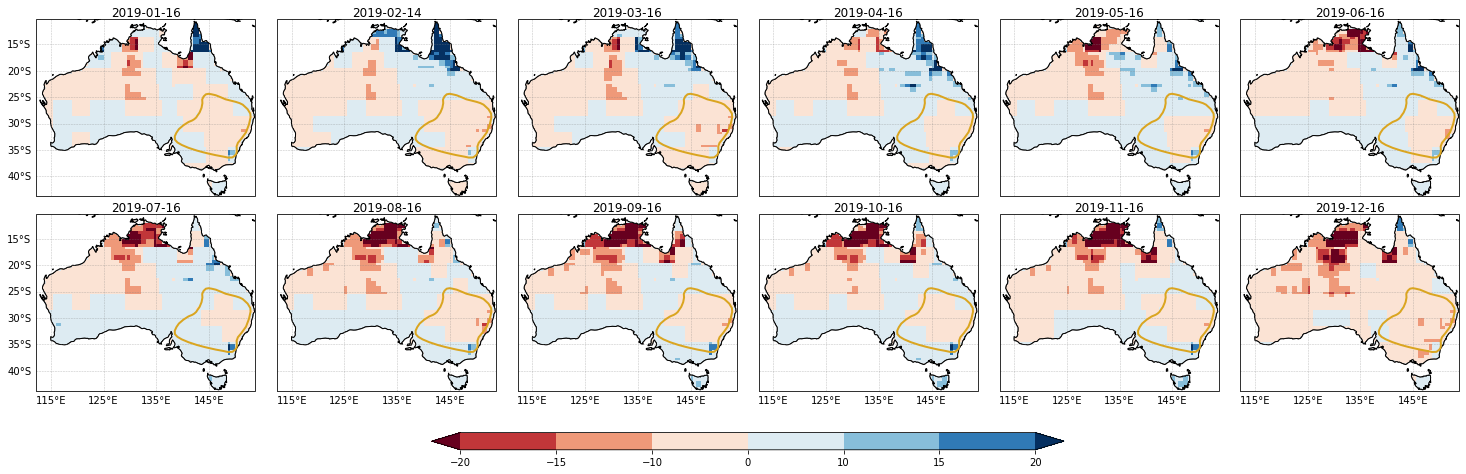

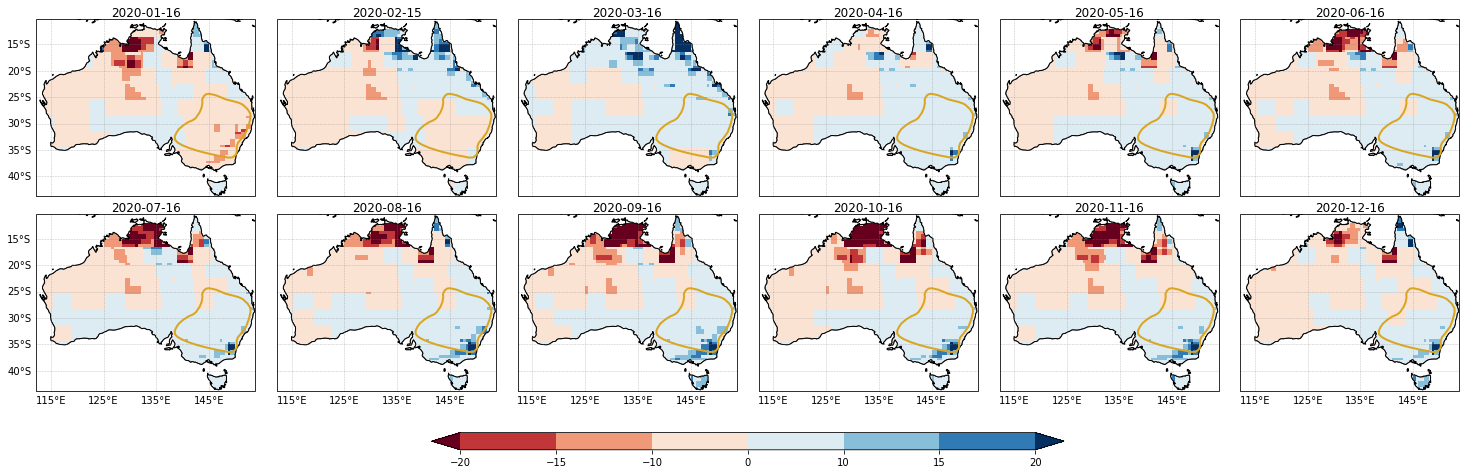

In [238]:
out_dir = 'figures/drought_2017to2020/grace/'
figname_prefix = 'grace_massChangesXscaleFact'

sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'

current_cmap = matplotlib.cm.get_cmap("RdBu").copy()
current_cmap.set_bad(color='lightgrey')

for year in [2017, 2018, 2019, 2020]:
    da_year = da_lwe_xSF.sel(time = str(year))
    plot_list = [da_year.isel(time = i) for i in range(len(da_year.time.values))] 
    
    # find the months for which the values are missing & place an empty data array there
    mon_array = np.array(range(1, 13))
    nanInd = [x not in da_year['time.month'].values for x in mon_array]
    for i in range(len(nanInd)):
        if nanInd[i]:
            da_temp = da_nan.assign_coords({'time':datetime.datetime(year,i+1,15)})
            plot_list.insert(i, da_temp)
    
    subplot_title = [np.datetime_as_string(x.time.values, unit='D') for x in plot_list]
    for i in range(len(nanInd)):
        if nanInd[i]:
            subplot_title[i] = np.datetime_as_string(plot_list[i].time.values, unit='M') + ', missing'

    levels = [-20, -15, -10, 0, 10, 15, 20]
    out_figname = figname_prefix + '_' + str(year)
    myfuncs.draw_pcolormesh_Npanels(plot_list, cmap = current_cmap, levels = levels, ncols = 6, nrows = 2, 
                                    subplot_title = subplot_title, shapefile = sh_file, shapefile_color = 'goldenrod',
                                    out_dir = out_dir, out_figname = out_figname)

### The anomalies of mass changes x scale factor from monthly climatology

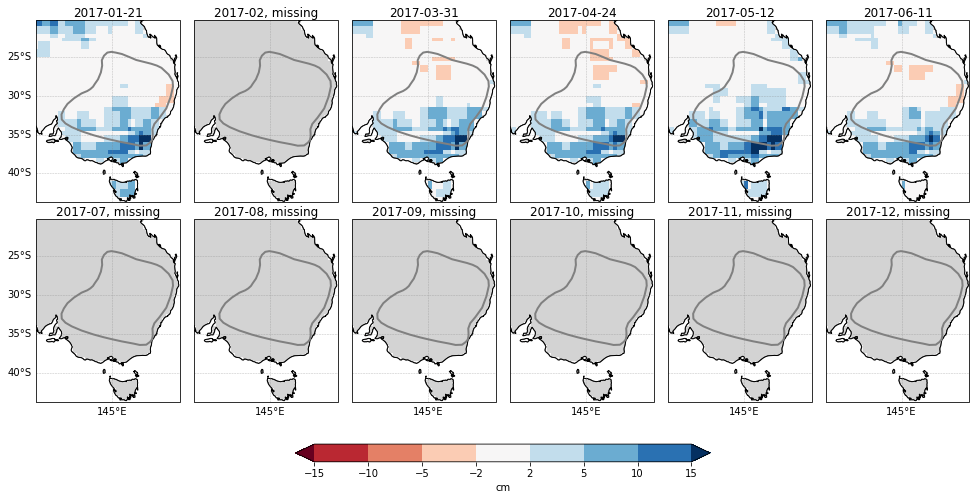

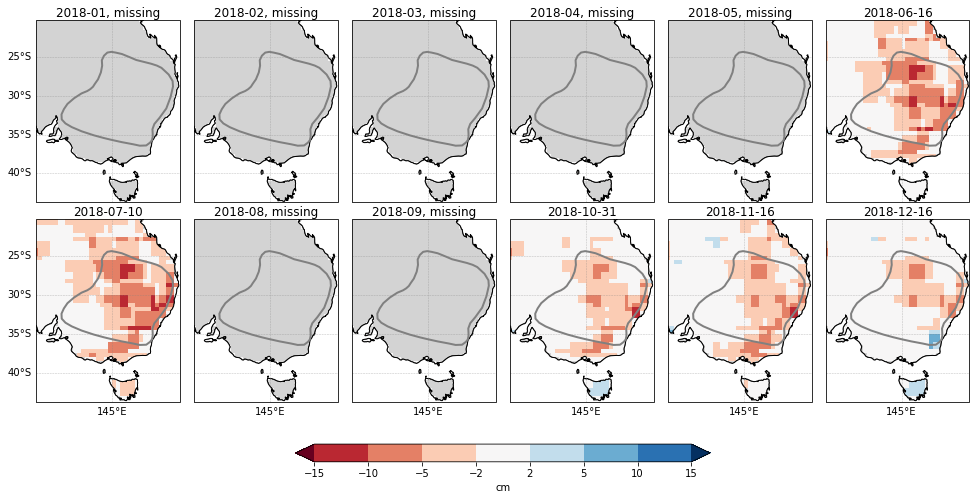

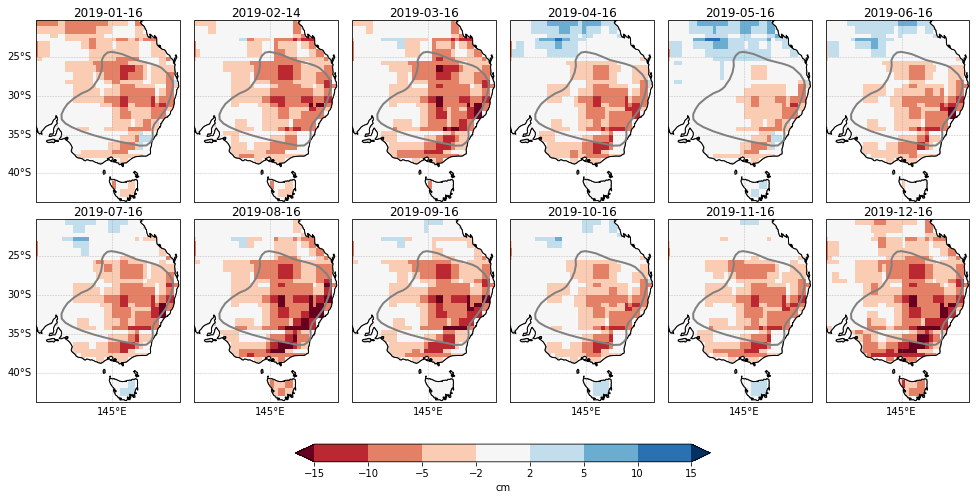

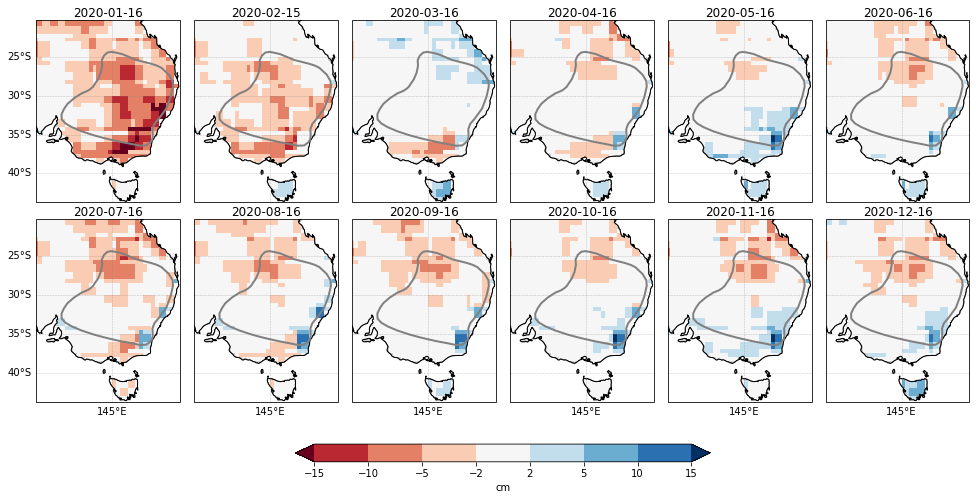

In [266]:
out_dir = 'figures/drought_2017to2020/grace/'
figname_prefix = 'grace_XscaleFact_anomalies_fromMonClim'

sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'

current_cmap = matplotlib.cm.get_cmap("RdBu").copy()
current_cmap.set_bad(color='lightgrey')

for year in [2017, 2018, 2019, 2020]:
    da_year = da_lwe_xSF_monAnom.sel(time = str(year), lat=lat_slice_small, lon=lon_slice_small)
    plot_list = [da_year.isel(time = i) for i in range(len(da_year.time.values))] 
    
    # find the months for which the values are missing & place an empty data array there
    mon_array = np.array(range(1, 13))
    nanInd = [x not in da_year['time.month'].values for x in mon_array]
    for i in range(len(nanInd)):
        if nanInd[i]:
            da_temp = da_nan.sel(lat=lat_slice_small, lon=lon_slice_small).assign_coords({'time':datetime.datetime(year,i+1,15)})
            plot_list.insert(i, da_temp)
    
    subplot_title = [np.datetime_as_string(x.time.values, unit='D') for x in plot_list]
    for i in range(len(nanInd)):
        if nanInd[i]:
            subplot_title[i] = np.datetime_as_string(plot_list[i].time.values, unit='M') + ', missing'

    levels = [-15, -10, -5, -2, 2, 5, 10, 15]
    out_figname = figname_prefix + '_' + str(year)
    myfuncs.draw_pcolormesh_Npanels(plot_list, cmap = current_cmap, levels = levels, ncols = 6, nrows = 2, panel_width=2.4, panel_height=4.1,
                                    subplot_title = subplot_title, shapefile = sh_file, shapefile_color = 'grey', #'goldenrod',
                                    out_dir = out_dir, out_figname = out_figname, cbar_label='cm')

## Area mean

In [10]:
# get a region mask using the drought focus region shapefile
import regionmask

# read in the focus region shapefile
drought_focusReg = gpd.read_file('/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp')

# # create a mask of the polygon for the lat-long values in ds. The mask would contain '0' inside the region; nan otherwise
# da_mask_zeros = regionmask.mask_geopandas(geodataframe = drought_focusReg, lon_or_obj = da_lwe_monAnom.lon.values, lat = da_lwe_monAnom.lat.values)
# # setting the points inside the region to 1
# da_mask = xr.where(da_mask_zeros == 0, 1, np.nan)

# # save the mask into a netcdf file
# out_file = '/g/data/w97/ad9701/drought_2017to2020/GRACE_mask_drought_focusArea.nc'
# da_mask.to_netcdf(out_file)

# read from saved file
out_file = '/g/data/w97/ad9701/drought_2017to2020/GRACE_mask_drought_focusArea.nc'
ds_mask = xr.open_dataset(out_file)
da_mask = ds_mask['mask']

In [21]:
da_lwe_monClim_masked = da_lwe_monClim*da_mask
da_lwe_monClim_regAvg = myfuncs.calc_areaAvg(da_lwe_monClim_masked)

da_lwe_monClim_04to09_masked = da_lwe_monClim_04to09*da_mask
da_lwe_monClim_04to09_regAvg = myfuncs.calc_areaAvg(da_lwe_monClim_04to09_masked)

NameError: name 'da_lwe_monClim_04to09' is not defined

In [12]:
da_lwe_monAnom_masked = da_lwe_monAnom*da_mask
da_lwe_monAnom_regAvg = myfuncs.calc_areaAvg(da_lwe_monAnom_masked)

da_lwe_masked = da_lwe*da_mask
da_lwe_regAvg = myfuncs.calc_areaAvg(da_lwe_masked)

da_lwe_std_masked = da_lwe_std*da_mask
da_lwe_std_regAvg = myfuncs.calc_areaAvg(da_lwe_std_masked)

da_lwe_monClim_masked = da_lwe_monClim*da_mask
da_lwe_monClim_regAvg = myfuncs.calc_areaAvg(da_lwe_monClim_masked)

In [13]:
missing_list = []

# find and insert nans for missing values
for year in [2017, 2018, 2019, 2020]:
    da_year = da_lwe_monAnom_regAvg.sel(time = str(year))

    # find the months for which the values are missing & place an empty data array there
    mon_array = np.array(range(1, 13))
    nanInd = [x not in da_year['time.month'].values for x in mon_array]
    for i in range(len(nanInd)):
        if nanInd[i]:
            da_temp = xr.DataArray(np.nan, coords={'time':datetime.datetime(year,i+1,15)})
            missing_list.append(da_temp)

In [14]:
da_missing = xr.concat(missing_list, dim='time')
da_lwe_monAnom_regAvg = da_lwe_monAnom_regAvg.drop('month')

In [15]:
da_lwe_monAnom_regAvg_wNan = xr.concat([da_lwe_monAnom_regAvg, da_missing], dim = 'time').sortby('time')
da_lwe_std_regAvg_wNan = xr.concat([da_lwe_std_regAvg, da_missing], dim = 'time').sortby('time')

In [16]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

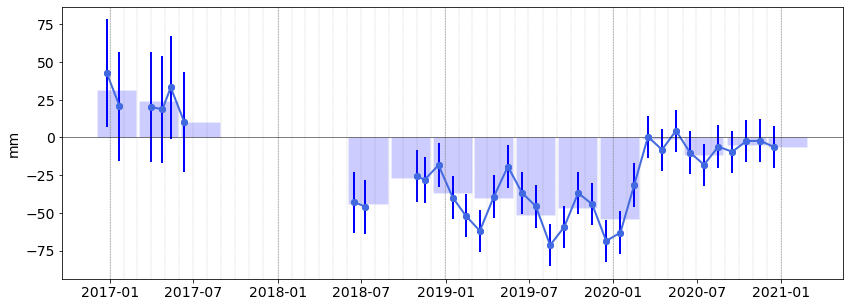

In [17]:
import pandas as pd
out_dir = 'figures/drought_2017to2020/grace/'

#da_lwe_monAnom_regAvg_wNan.plot.line(color="royalblue", marker="o", linewidth=1, size=5, aspect=3)
fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

xx = da_lwe_monAnom_regAvg_wNan.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
array_time = [x.astype('datetime64[D]') for x in xx]

array_val = da_lwe_monAnom_regAvg_wNan.resample(time="QS-DEC").mean().values*10
plt.bar(array_time, array_val, width=85, edgecolor='white', color='blue', alpha=0.2)

plt.errorbar(da_lwe_monAnom_regAvg_wNan.time.values, da_lwe_monAnom_regAvg_wNan.values*10, yerr=da_lwe_std_regAvg_wNan.values*10, fmt='o', color='royalblue',
             ecolor='blue', elinewidth=2, capsize=0)
plt.plot(da_lwe_monAnom_regAvg_wNan.time.values, da_lwe_monAnom_regAvg_wNan.values*10, color="royalblue", marker="o", linewidth=2)

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)
plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
plt.xlabel('')
plt.ylabel('mm')

fig.savefig(out_dir + 'areaAvg_GRACE_anom_from_monClim_inmm_600dpi.png', bbox_inches='tight', dpi=600)
fig.savefig(out_dir + 'areaAvg_GRACE_anom_from_monClim_inmm.pdf', bbox_inches='tight', format='pdf')

NameError: name 'da_lwe_monClim_04to09_regAvg' is not defined

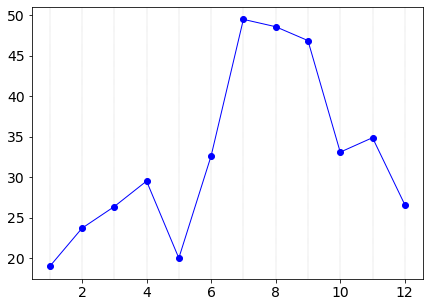

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(7,5)) #width, height

for xline in range(1, 13):
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)

plt.plot(da_lwe_monClim_regAvg.month.values, da_lwe_monClim_regAvg.values*10, color='blue', marker="o", linewidth=1, label='2002-04 to 2021-12')
plt.plot(da_lwe_monClim_04to09_regAvg.month.values, da_lwe_monClim_04to09_regAvg.values*10, color='black', marker="o", linewidth=1, label = '2004-01 to 2009-12')
plt.xlabel('month')
plt.ylabel('mm')
plt.ylim((-25, 60))
plt.axhline(0, linestyle='--', color='grey', linewidth=0.5)
plt.legend(loc=0)

fig.savefig(out_dir + 'grace_monClim_inmm_w04to09.png', bbox_inches='tight', dpi=600)
fig.savefig(out_dir + 'grace_monClim_inmm_w04to09.pdf', bbox_inches='tight', format='pdf')

In [19]:
da_lwe_masked = da_lwe*da_mask
da_lwe_regAvg = myfuncs.calc_areaAvg(da_lwe_masked)

In [20]:
missing_list = []

# find and insert nans for missing values
for year in [2017, 2018, 2019, 2020]:
    da_year = da_lwe_regAvg.sel(time = str(year))

    # find the months for which the values are missing & place an empty data array there
    mon_array = np.array(range(1, 13))
    nanInd = [x not in da_year['time.month'].values for x in mon_array]
    for i in range(len(nanInd)):
        if nanInd[i]:
            da_temp = xr.DataArray(np.nan, coords={'time':datetime.datetime(year,i+1,15)})
            missing_list.append(da_temp)
            
da_missing = xr.concat(missing_list, dim='time')
da_lwe_regAvg_wNan = xr.concat([da_lwe_regAvg, da_missing], dim = 'time').sortby('time')

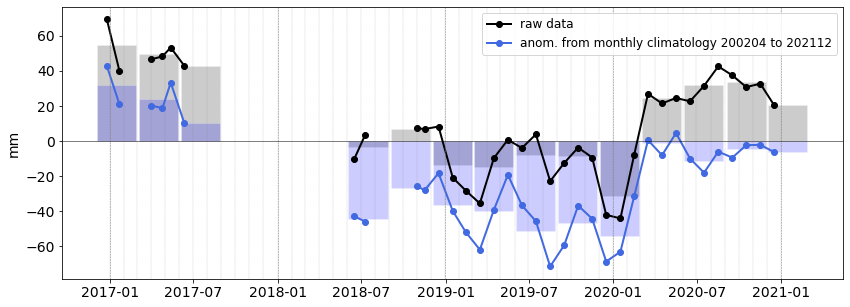

In [23]:
import pandas as pd

#da_lwe_monAnom_regAvg_wNan.plot.line(color="royalblue", marker="o", linewidth=1, size=5, aspect=3)
fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

xx = da_lwe_regAvg_wNan.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
array_time = [x.astype('datetime64[D]') for x in xx]

array_val = da_lwe_regAvg_wNan.resample(time="QS-DEC").mean().values*10
plt.bar(array_time, array_val, width=85, edgecolor='white', color='black', alpha=0.2)

# plt.errorbar(da_lwe_monAnom_regAvg_wNan.time.values, da_lwe_monAnom_regAvg_wNan.values*10, yerr=da_lwe_std_regAvg_wNan.values*10, fmt='o', color='royalblue',
#              ecolor='blue', elinewidth=3, capsize=0)

plt.plot(da_lwe_regAvg_wNan.time.values, da_lwe_regAvg_wNan.values*10, color="black", marker="o", linewidth=2, label = 'raw data')

xx = da_lwe_monAnom_regAvg_wNan.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
array_time = [x.astype('datetime64[D]') for x in xx]

array_val = da_lwe_monAnom_regAvg_wNan.resample(time="QS-DEC").mean().values*10
plt.bar(array_time, array_val, width=85, edgecolor='white', color='blue', alpha=0.2)

plt.plot(da_lwe_monAnom_regAvg_wNan.time.values, da_lwe_monAnom_regAvg_wNan.values*10, color="royalblue", marker="o", linewidth=2, label = 'anom. from monthly climatology 200204 to 202112')

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)
plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
plt.xlabel('')
plt.ylabel('mm')
plt.legend()

fig.savefig(out_dir + 'areaAvg_GRACE_rawData_and_monAnom_inmm.png', bbox_inches='tight')

### Anomalies in % (to mention in the text)

In [23]:
anom_seasMean = da_lwe_monAnom_regAvg_wNan.resample(time="QS-DEC").mean()
clim_seasMean = da_lwe_monClim_regAvg.sel(month = da_lwe_monAnom_regAvg_wNan['time.month'].values).rename({'month':'time'})\
.assign_coords({'time':da_lwe_monAnom_regAvg_wNan.time.values}).resample(time="QS-DEC").mean()

df_anom = pd.DataFrame({'season':anom_seasMean.time.values,
                        'anomaly (mm)': np.round(anom_seasMean, 5).values,
                        #'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       'climatology (mm)': np.round(clim_seasMean, 5).values})
print(df_anom)

out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/seas_grace_anomalies.csv'
df_anom.to_csv(out_file)

       season  anomaly (mm)  climatology (mm)
0  2016-12-01       3.17536           2.30736
1  2017-03-01       2.40321           2.52786
2  2017-06-01       1.02935           4.35419
3  2017-09-01           NaN           3.82566
4  2017-12-01           NaN           2.30736
5  2018-03-01           NaN           2.52786
6  2018-06-01      -4.43819           4.35419
7  2018-09-01      -2.69171           3.82566
8  2018-12-01      -3.67120           2.30736
9  2019-03-01      -4.01430           2.52786
10 2019-06-01      -5.12488           4.35419
11 2019-09-01      -4.68305           3.82566
12 2019-12-01      -5.43852           2.30736
13 2020-03-01      -0.10353           2.52786
14 2020-06-01      -1.13698           4.35419
15 2020-09-01      -0.46798           3.82566
16 2020-12-01      -0.63598           2.65852


In [25]:
anom_mon = da_lwe_monAnom_regAvg_wNan
clim_mon = da_lwe_monClim_regAvg.sel(month = da_lwe_monAnom_regAvg_wNan['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_lwe_monAnom_regAvg_wNan.time.values})

df_anom_mon = pd.DataFrame({'month':anom_mon.time.values,
                        'anomaly (m3/m3)': np.round(anom_mon, 5).values,
                        #'perc_anomaly (%)': np.round(anom_mon/clim_mon*100,1).values,
                        'climatology (m3/m3)': np.round(clim_mon, 5).values})
print(df_anom_mon)
out_file_mon = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/mon_grace_anomalies.csv'
df_anom_mon.to_csv(out_file_mon)

                 month  anomaly (m3/m3)  climatology (m3/m3)
0  2016-12-24 12:00:00          4.26901              2.65852
1  2017-01-21 00:00:00          2.08171              1.89590
2  2017-02-15 00:00:00              NaN              2.36766
3  2017-03-31 12:00:00          2.01749              2.63499
4  2017-04-24 12:00:00          1.87072              2.94981
5  2017-05-12 12:00:00          3.32141              1.99878
6  2017-06-11 00:00:00          1.02935              3.26043
7  2017-07-15 00:00:00              NaN              4.94648
8  2017-08-15 00:00:00              NaN              4.85567
9  2017-09-15 00:00:00              NaN              4.68447
10 2017-10-15 00:00:00              NaN              3.30709
11 2017-11-15 00:00:00              NaN              3.48543
12 2017-12-15 00:00:00              NaN              2.65852
13 2018-01-15 00:00:00              NaN              1.89590
14 2018-02-15 00:00:00              NaN              2.36766
15 2018-03-15 00:00:00  

In [59]:
da_lwe_monClim_04to09_regAvg.sel(month = da_lwe_regAvg_wNan['time.month'].values)

<xarray.DataArray (month: 49)>
array([-0.10501077, -0.57825932, -0.49661441, -1.31520496, -1.5060474 ,
       -1.49968311,  0.45488007,  1.35749496,  1.20068791,  1.29735395,
        0.56222851,  0.62817458, -0.10501077, -0.57825932, -0.49661441,
       -1.31520496, -1.5060474 , -1.49968311,  0.45488007,  1.35749496,
        1.20068791,  1.29735395,  0.56222851,  0.62817458, -0.10501077,
       -0.57825932, -0.49661441, -1.31520496, -1.5060474 , -1.49968311,
        0.45488007,  1.35749496,  1.20068791,  1.29735395,  0.56222851,
        0.62817458, -0.10501077, -0.57825932, -0.49661441, -1.31520496,
       -1.5060474 , -1.49968311,  0.45488007,  1.35749496,  1.20068791,
        1.29735395,  0.56222851,  0.62817458, -0.10501077])
Coordinates:
  * month    (month) int64 12 1 2 3 4 5 6 7 8 9 10 ... 2 3 4 5 6 7 8 9 10 11 12

Text(0.5, 0, '')

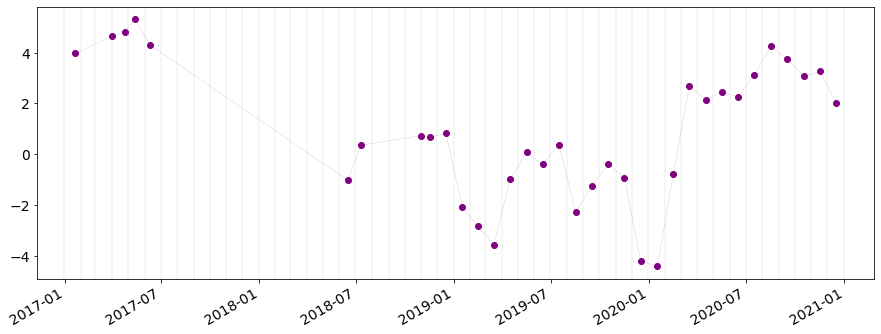

In [342]:
da_lwe_regAvg.plot.line(color="purple", marker="o", linewidth=0.1, size=5, aspect=3)
for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
plt.xlabel('')

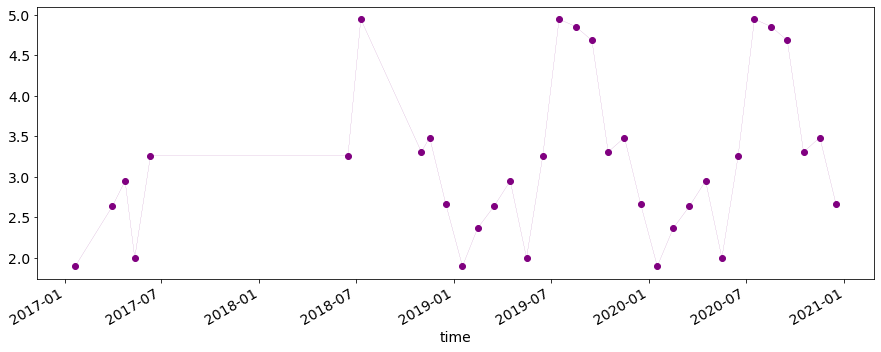

In [297]:
da_clim_forplot = da_lwe_monClim_regAvg.sel(month = da_lwe_monAnom_regAvg['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_lwe_monAnom_regAvg.time.values})
da_clim_forplot.plot.line(color="purple", marker="o", linewidth=0.1, size=5, aspect=3)